In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import DataFrameSet
from utils import *
import pandas as pd
from pathlib import Path

setting = 'fuji'

Available workers: 8


In [5]:
dfs = DataFrameSet(setting=setting)
dfs.extract_df_info()

In [6]:
dfs[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F99CF238AC0>,
 'bl',
 '2020_Herent_w28_3-30_F10_51 mm_ISO160_1-15 s_IncandescentWB_111',
 'Herent_w28_3-30_F10_51 mm_ISO160_1-15 s_IncandescentWB',
 '/media/kalfasyan/HGST_4TB/Datasets/pbox_vs_fuji/fuji/bl/2020_Herent_w28_3-30_F10_51 mm_ISO160_1-15 s_IncandescentWB_111.jpg',
 '111',
 'herent',
 'w28',
 '2020',
 '3-30')

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F99CBC99B80>, 'bl', '2021_UNDISTORTED_Landen_w24_B_F10_51 mmmm_ISO160_1-15 ss_IncandescentWB.png_376', 'UNDISTORTED_Landen_w24_B_F10_51 mmmm_ISO160_1-15 ss_IncandescentWB.png', '/media/kalfasyan/HGST_4TB/Datasets/pbox_vs_fuji/fuji/bl/2021_UNDISTORTED_Landen_w24_B_F10_51 mmmm_ISO160_1-15 ss_IncandescentWB.png_376.jpg', '376', 'landen', 'w24', '2021', 'B')


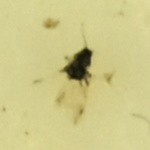

In [7]:
n=1
print(dfs[n])
dfs[n][0]